In [1]:
import numpy as np
import pandas as pd
import os

# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

# from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

sns.set()
from IPython.lib.display import IFrame

### Загрузим данные

In [4]:
train_sales = pd.read_excel("/data/train_sales_dist.xlsx",
                             parse_dates=True, index_col="Period")

In [5]:
customer = 2
correct_data = False #для 2 и 29

In [6]:
train_sales = train_sales.sort_index()
data = train_sales[train_sales['Customer'] == customer][['BPV']]

if customer in [18,34]: #для СНГ предсказания по месяцам
  data = data.resample('MS').apply(sum)


if customer in [18,34]:
  window=12 #год для помесячных (18 и 34 клиенты)
  test_size = 9  #9 месяцев
if customer in [2,14,29]:
  window=26 #6 месяцев для понедельных (2,14,29 клиенты)
  test_size = round(52/12*9) #9 месяцев


if customer in [18,34]:
  freq = "M"
if customer in [2,14,29]:
  freq = "W"

In [7]:
if correct_data:
  if customer == 2:
    data.loc[data.index<=pd.Timestamp("2020-02-24"),'BPV'] = data.loc[data.index<=pd.Timestamp("2020-02-24"),'BPV']/2
  elif customer == 29:
    data['BPV_gap'] = data['BPV'] 
    data.loc[data.index<pd.Timestamp("2020-01-01"),'BPV_gap'] = data['BPV'].shift(52)

    data = data[['BPV_gap']].rename({'BPV_gap':'BPV'}, axis=1)
    data = data.dropna()

# Staking 

In [11]:
from models import train_test_split, walk_forward_prediction

In [49]:
from metrics import *

In [32]:
class StakingModel():
  def __init__(self, final_model, base_models):
    self.final_model = final_model
    self.base_models = base_models
    self.target_column = None


  def get_metafeatures(self, train: pd.DataFrame, test: pd.DataFrame, target_column: str,  base_models: list):
    metafeatures = pd.DataFrame([], index = test.index)
    # получаем все мета-признаки - предсказания базовых моделей
    for i, model_config in enumerate(base_models):
      model = model_config['model']
      features = model_config['features']
      lags = model_config['lags']
      calc_features = model_config['calc_features']
      
      trues, preds = walk_forward_prediction(train, test,
                                             target_column = target_column,
                                             date_column = 'Period',
                                             features = features,
                                             model = model,
                                             lags = lags,
                                             calc_features = calc_features)
      
      metafeatures[f'model_{i}'] = preds
    return metafeatures


  def fit(self, train, target_column):
    self.target_column = target_column

    # найдем самый большой лаг, чтобы определить размер обучающей выборки для финальной модели стекинга
    max_lag = 0
    for model_config in self.base_models:
      lags = model_config['lags']
      max_lag = max(max_lag, max(lags))

    mini_train = train.iloc[max_lag:]
    train_metafeatures = self.get_metafeatures(train, mini_train, self.target_column, self.base_models)
    train_target = mini_train[self.target_column]

    self.final_model.fit(train_metafeatures, train_target)


  def predict(self, train, test):
    test_metafeatures = self.get_metafeatures(train, test, self.target_column, self.base_models)
    preds = self.final_model.predict(test_metafeatures)
    return preds, test_metafeatures

In [33]:
# определим конфигурацию базовых моделей
base_models = [
               {
                'model': lgb.LGBMRegressor(objective='mae'),
                'features': [],
                'lags': range(1,6),
                'calc_features': {
                    'on_weekmean': False,
                    'on_monthmean': False,
                    'on_date ': False,
                    'on_monthpart': False,
                    'on_diff': False
                    }
               },
               {
                'model': lgb.LGBMRegressor(objective='mae'),
                'features': [],
                'lags': range(1,9),
                'calc_features': {
                    'on_weekmean': False,
                    'on_monthmean': False,
                    'on_date ': True,
                    'on_monthpart': False,
                    'on_diff': True
                    }
               },
               {
                'model': lgb.LGBMRegressor(objective='mae'),
                'features': [],
                'lags': range(1,6),
                'calc_features': {
                    'on_weekmean': True,
                    'on_monthmean': False,
                    'on_date ': False,
                    'on_monthpart': False,
                    'on_diff': True
                    }
               }
]

In [34]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [68]:
train, test = train_test_split(data[['BPV']], 39)
sm = StakingModel(LinearRegression(), base_models)
sm.fit(train, 'BPV')
preds, meta = sm.predict(train, test)

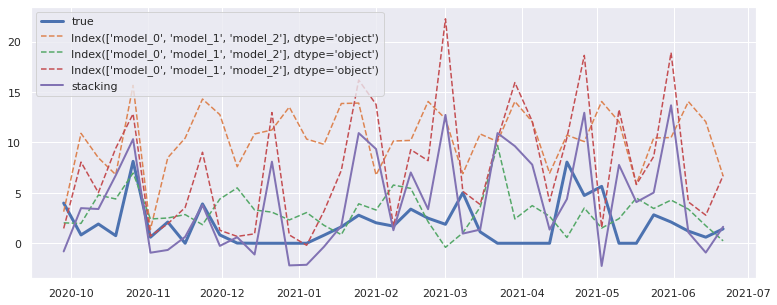

In [69]:
plt.figure(figsize = (13,5))
plt.plot(test.index, test['BPV'], linewidth=3, label ='true')
plt.plot(test.index, meta, label = meta.columns, linestyle='--')
plt.plot(test.index, preds, linewidth=2, label='stacking')

plt.legend()

In [70]:
wape(*resample_monthly(test['BPV'], preds))

1.4388177392427965

In [65]:
train, test = train_test_split(data[['BPV']], 39)
sm = StakingModel(lgb.LGBMRegressor(), base_models)
sm.fit(train, 'BPV')
preds, meta = sm.predict(train, test)

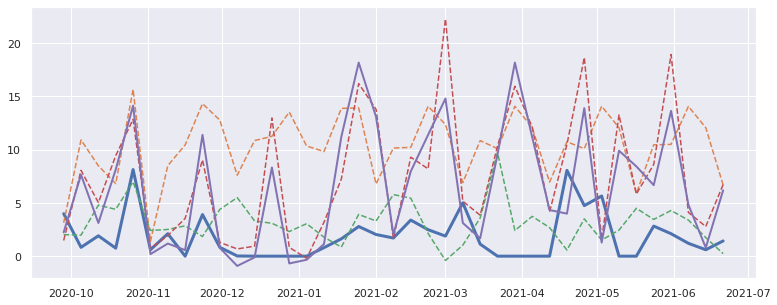

In [66]:
plt.figure(figsize = (13,5))
plt.plot(test.index, test['BPV'], linewidth=3, label ='true')
plt.plot(test.index, meta, label = meta.columns, linestyle='--')
plt.plot(test.index, preds, linewidth=2, label='stacking')

# plt.legend()

In [67]:
wape(*resample_monthly(test['BPV'], preds))

2.536840190418275